In [1]:
import pickle
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from asgn3.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from asgn3.rnn_layers import *
from asgn3.captioning_solver import CaptioningSolver
from asgn3.classifiers.rnn import CaptioningRNN
from asgn3.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from asgn3.image_utils import image_from_url
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
data=pickle.load(open("../0.8s_rnn_rand.p","rb"))
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  else:
    print k, type(v), len(v)

X_val <type 'numpy.ndarray'> (234, 204, 3) float64
X_train <type 'numpy.ndarray'> (936, 204, 3) float64
X_test <type 'numpy.ndarray'> (292, 204, 3) float64
test_features <type 'numpy.ndarray'> (292, 204, 3) float64
idx_to_word <type 'dict'> 32
train_captions <type 'numpy.ndarray'> (936, 17) int64
val_captions <type 'numpy.ndarray'> (234, 17) int64
test_captions <type 'numpy.ndarray'> (292, 17) int64
val_features <type 'numpy.ndarray'> (234, 204, 3) float64
y_val <type 'numpy.ndarray'> (234, 17) int64
y_train <type 'numpy.ndarray'> (936, 17) int64
train_features <type 'numpy.ndarray'> (936, 204, 3) float64
y_test <type 'numpy.ndarray'> (292, 17) int64
word_to_idx <type 'dict'> 32


In [40]:
X_train,y_train=data['train_features'],data['train_captions']
# X_val,y_val=data['X_val'],data['y_val']
# num_classes=len(data['char_to_indx'])
# def reformat(dataset):
#   dataset = dataset.reshape((dataset.shape[0], -1)).astype(np.float32)
#   return dataset
# X_train=reformat(X_train)
# X_val=reformat(X_val)
print "number of nan values:",np.count_nonzero(np.isnan(X_train))
print "number of inf values:",np.count_nonzero(np.isinf(X_train))

number of nan values: 0
number of inf values: 0


In [41]:
train_features=data['train_features']
diff=rel_error(train_features[0],train_features[1])
print diff

1.0


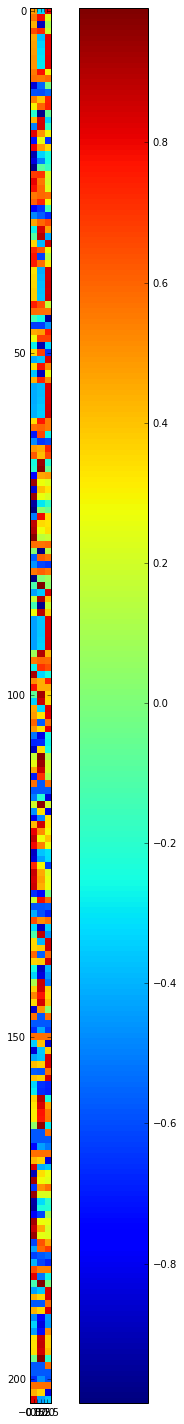

In [30]:
#see a few feature vectors
F = plt.gcf()
F.set_size_inches(10, 25, forward=True)#Set forward to True to resize window along with plot in figure.
plt.imshow(data['X_train'][2], interpolation='nearest')
plt.colorbar()
plt.savefig('../feature2.jpg')
plt.show()

In [3]:
from sklearn.decomposition import PCA

def reformat(dataset):
  pca = PCA(n_components=300)
  dataset = dataset.reshape((dataset.shape[0], -1)).astype(np.float32)
#   dataset=pca.fit_transform(dataset)
  return dataset
data['train_features']=reformat(data['train_features'])
data['val_features']=reformat(data['val_features'])
data['test_features']=reformat(data['test_features'])
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  else:
    print k, type(v), len(v)

X_val <type 'numpy.ndarray'> (234, 204, 3) float64
X_train <type 'numpy.ndarray'> (936, 204, 3) float64
X_test <type 'numpy.ndarray'> (292, 204, 3) float64
test_features <type 'numpy.ndarray'> (292, 612) float32
idx_to_word <type 'dict'> 32
train_captions <type 'numpy.ndarray'> (936, 17) int64
val_captions <type 'numpy.ndarray'> (234, 17) int64
test_captions <type 'numpy.ndarray'> (292, 17) int64
val_features <type 'numpy.ndarray'> (234, 612) float32
y_val <type 'numpy.ndarray'> (234, 17) int64
y_train <type 'numpy.ndarray'> (936, 17) int64
train_features <type 'numpy.ndarray'> (936, 612) float32
y_test <type 'numpy.ndarray'> (292, 17) int64
word_to_idx <type 'dict'> 32


In [32]:
fc_hidden_dims = [512,512,512,512,512,512,512]
dropouts=[0.1,0.25,0.5]
regs=[1e-6,1e-5]
weight_scale = 1e-3
learning_rates=[8e-6,3e-5,8e-5]
lr_decay=0.99
input_dims=[256,512] #the input dimension to RNN from FNN. can be any arbitrary number
best_loss=float('inf')
best_model=None
best_lr=None

num_train = 100
for dropout in dropouts:
    for reg in regs:
        for learning_rate in learning_rates:
            for input_dim in input_dims:
                print "TRYING....DROPOUT:", dropout
                print "REG:", reg
                print "INPUT_DIM", input_dim
                print "LR", learning_rate
                print ""
                mask=np.random.choice(data['train_features'].shape[0],num_train)
                small_data = {
                  'train_features': data['train_features'][mask],
                  'train_captions': data['train_captions'][mask],
                  'val_features': data['val_features'],
                  'val_captions': data['val_captions'],
                  'test_features': data['test_features'],
                  'test_captions': data['test_captions'],
                  'word_to_idx': data['word_to_idx'],
                  'idx_to_word': data['idx_to_word'],
                }

                small_lstm_model = CaptioningRNN(
                          cell_type='lstm',
                          word_to_idx=data['word_to_idx'],
                          fc_hidden_dims=fc_hidden_dims,
                          fc_input_dim=data['train_features'].shape[1],
                          input_dim=input_dim,
                          hidden_dim=1024,
                          wordvec_dim=256,
                          dtype=np.float64,
                          weight_scale=weight_scale, 
                          use_batchnorm=True, 
                          dropout=dropout,
                          reg=reg
                        )

                small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
                           update_rule='adam',
                           num_epochs=30,
                           batch_size=25,
                           optim_config={
                             'learning_rate': learning_rate,
                           },
                           lr_decay=lr_decay,
                           verbose=True, print_every=50,
                         )

                small_lstm_solver.train()
                
                curr_loss=small_lstm_solver.loss_history[-1]
                if best_loss>curr_loss:
                    print "BEST LOSS:", curr_loss
                    print "DROPOUT:", dropout
                    print "REG:", reg
                    print "INPUT_DIM", input_dim
                    print "LR", learning_rate
                    print ""
                    best_loss=curr_loss
                    best_model=CaptioningRNN(
                          cell_type='lstm',
                          word_to_idx=data['word_to_idx'],
                          fc_hidden_dims=fc_hidden_dims,
                          fc_input_dim=data['train_features'].shape[1],
                          input_dim=input_dim,
                          hidden_dim=1024,
                          wordvec_dim=256,
                          dtype=np.float64,
                          weight_scale=weight_scale, 
                          use_batchnorm=True, 
                          dropout=dropout,
                          reg=reg
                        )
                    best_lr=learning_rate

TRYING....DROPOUT: 0.1
REG: 1e-06
INPUT_DIM 256
LR 8e-06

(Iteration 1 / 120) loss: 21.488776


KeyboardInterrupt: 

(Iteration 1 / 400) loss: 16.912377
(Iteration 51 / 400) loss: 13.488019
(Iteration 101 / 400) loss: 16.196737
(Iteration 151 / 400) loss: 15.384220
(Iteration 201 / 400) loss: 13.066544
(Iteration 251 / 400) loss: 13.511517
(Iteration 301 / 400) loss: 13.125704
(Iteration 351 / 400) loss: 15.950197


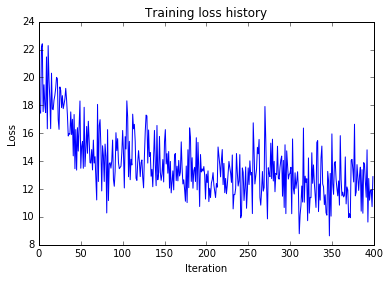

In [19]:
fc_hidden_dims = [512,512,512,512,512,512,512]
dropouts=[0.1,0.25,0.5]
regs=[1e-6,1e-5]
weight_scale = 1e-3
learning_rates=[8e-6,3e-5,8e-5]
lr_decay=0.99
input_dims=[256,512] #the input dimension to RNN from FNN. can be any arbitrary number
best_loss=float('inf')
best_model=None
best_lr=None

num_train = 200
mask=np.random.choice(data['train_features'].shape[0],num_train)
small_data = {
  'train_features': data['train_features'][mask],
  'train_captions': data['train_captions'][mask],
  'val_features': data['val_features'],
  'val_captions': data['val_captions'],
  'test_features': data['test_features'],
  'test_captions': data['test_captions'],
  'word_to_idx': data['word_to_idx'],
  'idx_to_word': data['idx_to_word'],
}

best_model=CaptioningRNN(
                          cell_type='lstm',
                          word_to_idx=data['word_to_idx'],
                          fc_hidden_dims=fc_hidden_dims,
                          fc_input_dim=data['train_features'].shape[1],
                          input_dim=512,
                          hidden_dim=1024,
                          wordvec_dim=256,
                          dtype=np.float64,
                          weight_scale=weight_scale, 
                          use_batchnorm=True, 
                          dropout=0.1,
                          reg=1e-6
                        )
best_lr=4e-5                    
                    
small_lstm_solver = CaptioningSolver(best_model, small_data,
                           update_rule='adam',
                           num_epochs=50,
                           batch_size=25,
                           optim_config={
                             'learning_rate': best_lr,
                           },
                           lr_decay=lr_decay,
                           verbose=True, print_every=50,
                         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [20]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
  gt_captions, features = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = best_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  print split,":"
  print "Ground Truth:",gt_captions
  print "Sampled:",sample_captions
  print ""

train :
Ground Truth: ['<START> t i m e <END>', '<START> <lshft> i d <END>']
Sampled: ['t h e <END>', '<lshft> i <END>']

val :
Ground Truth: ['<START> <lshft> e d w a r d <END>', '<START> f r i e n d s <END>']
Sampled: ['p o e e e <END>', 'o i e <END>']

